In [2]:
import urllib.request
import bz2
import os

url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
compressed_path = "shape_predictor_68_face_landmarks.dat.bz2"
extracted_path = "shape_predictor_68_face_landmarks.dat"

if not os.path.exists(extracted_path):
    print("Downloading landmark model...")
    urllib.request.urlretrieve(url, compressed_path)

    print("Extracting...")
    with bz2.BZ2File(compressed_path) as fr, open(extracted_path, "wb") as fw:
        fw.write(fr.read())

    print("Done.")
else:
    print("Landmark model already exists.")

Extracting...
Done.



==================== EXTRACT PER-FRAME ====================
/content/vidS1.mp4: frames=112, detected_frames=111, detection_rate=99.1%
/content/vidS2.mp4: frames=110, detected_frames=110, detection_rate=100.0%

==================== LANDMARK SUMMARY ====================

Facial landmark detection summary (dlib-68):
  Total aligned frames compared: 110
  /content/vidS1.mp4: frames with 0 landmarks = 1, frames with 68 landmarks = 109
  /content/vidS2.mp4: frames with 0 landmarks = 0, frames with 68 landmarks = 110
  Both videos: frames where BOTH had 0 landmarks = 0
  Both videos: frames where BOTH had full 68 landmarks = 109
  Mean valid points (when detected) video1: 68.00 / 68
  Mean valid points (when detected) video2: 68.00 / 68

==================== LATENCY ====================
Video1 latency: avg=109.47 ms/frame, p95=156.86 ms, total_time=12.51 s
Video2 latency: avg=109.78 ms/frame, p95=155.70 ms, total_time=12.31 s

==================== STABILITY (still segment) ==================

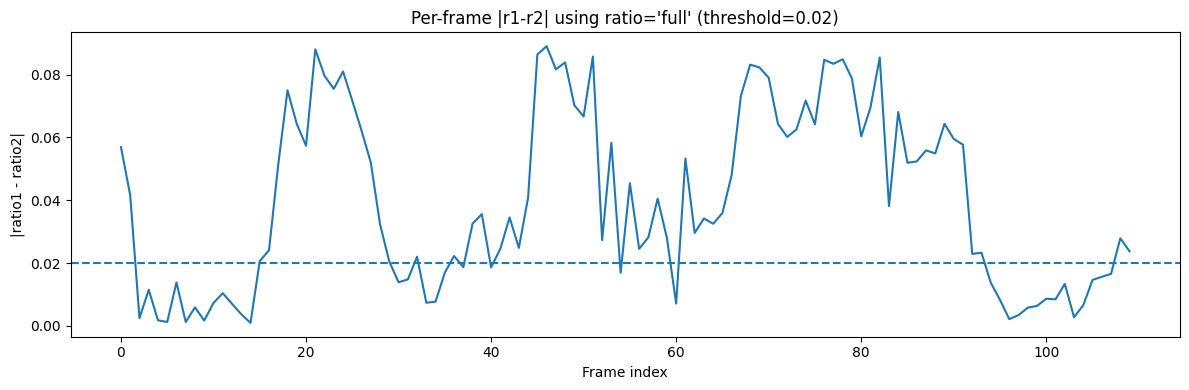


==================== TOP-K MOST SIMILAR FRAMES ====================
Using ratio='full' | per-frame SIMILAR if |diff| <= 0.02
  Frame 14: r1=0.0758, r2=0.0749, |diff|=0.0009 => SIMILAR | pts1=68(valid 68), pts2=68(valid 68)
  Frame 7: r1=0.0686, r2=0.0674, |diff|=0.0012 => SIMILAR | pts1=68(valid 68), pts2=68(valid 68)
  Frame 5: r1=0.0715, r2=0.0727, |diff|=0.0012 => SIMILAR | pts1=68(valid 68), pts2=68(valid 68)
  Frame 9: r1=0.0623, r2=0.0606, |diff|=0.0017 => SIMILAR | pts1=68(valid 68), pts2=68(valid 68)
  Frame 4: r1=0.0706, r2=0.0724, |diff|=0.0017 => SIMILAR | pts1=68(valid 68), pts2=68(valid 68)
  Frame 96: r1=0.0700, r2=0.0679, |diff|=0.0021 => SIMILAR | pts1=68(valid 68), pts2=68(valid 68)
  Frame 2: r1=0.0813, r2=0.0838, |diff|=0.0024 => SIMILAR | pts1=68(valid 68), pts2=68(valid 68)
  Frame 103: r1=0.0740, r2=0.0713, |diff|=0.0027 => SIMILAR | pts1=68(valid 68), pts2=68(valid 68)
  Frame 97: r1=0.0691, r2=0.0657, |diff|=0.0034 => SIMILAR | pts1=68(valid 68), pts2=68(valid 

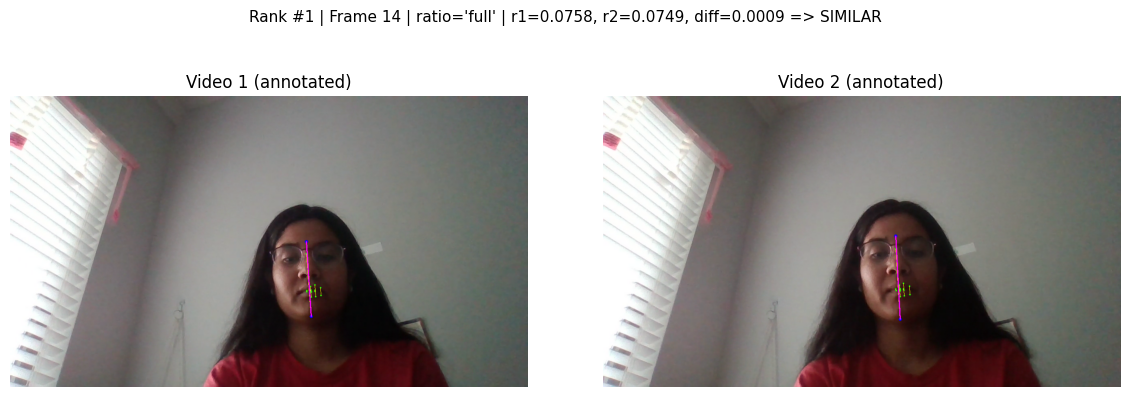

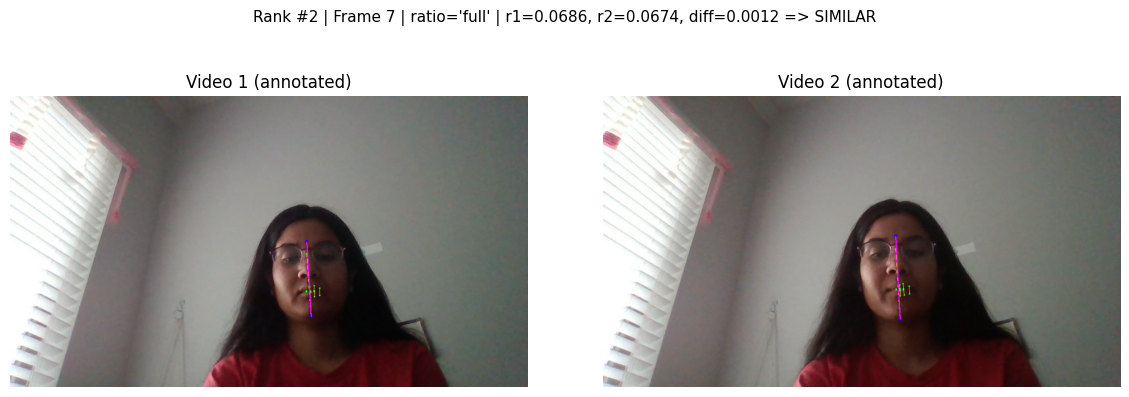

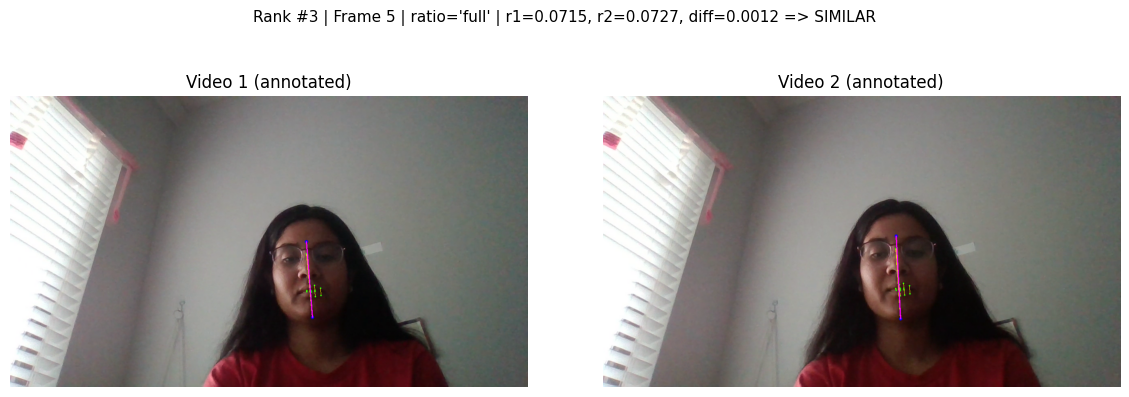

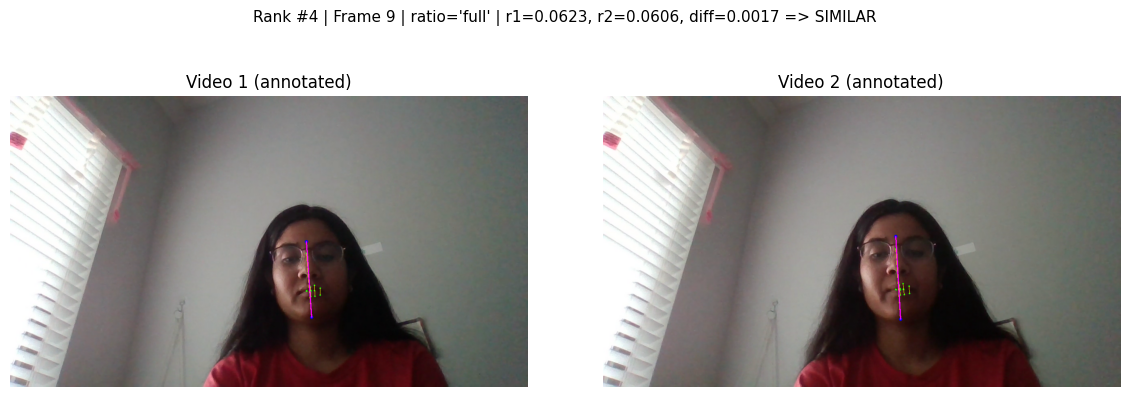

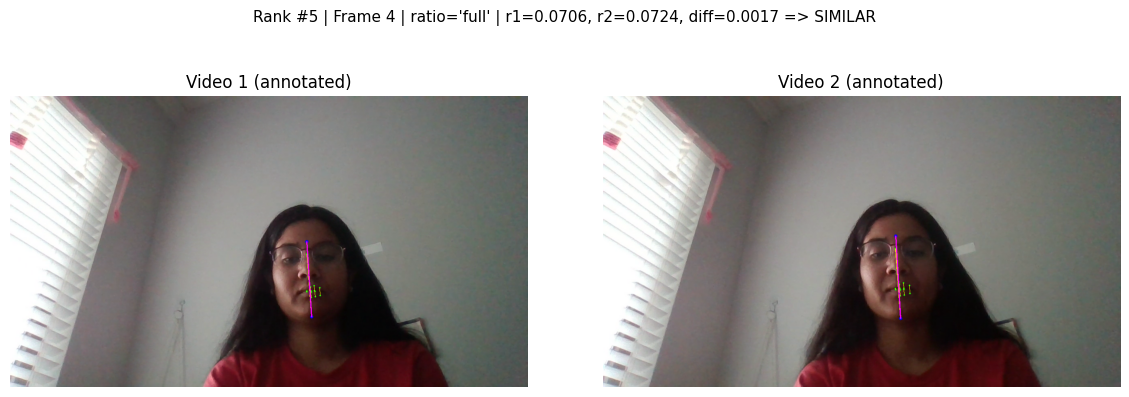

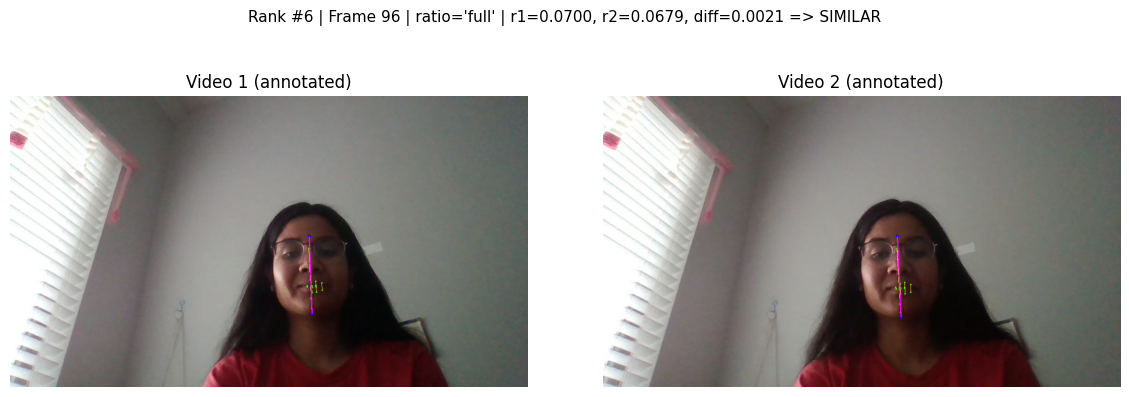

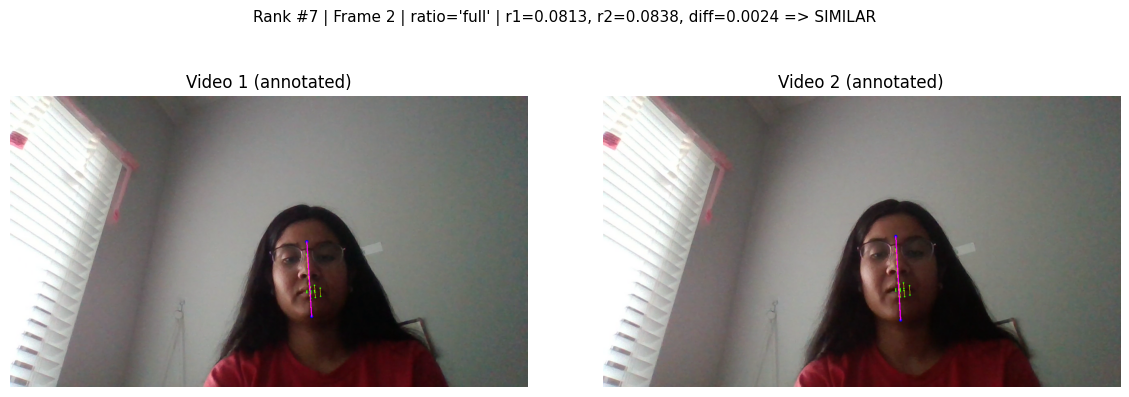

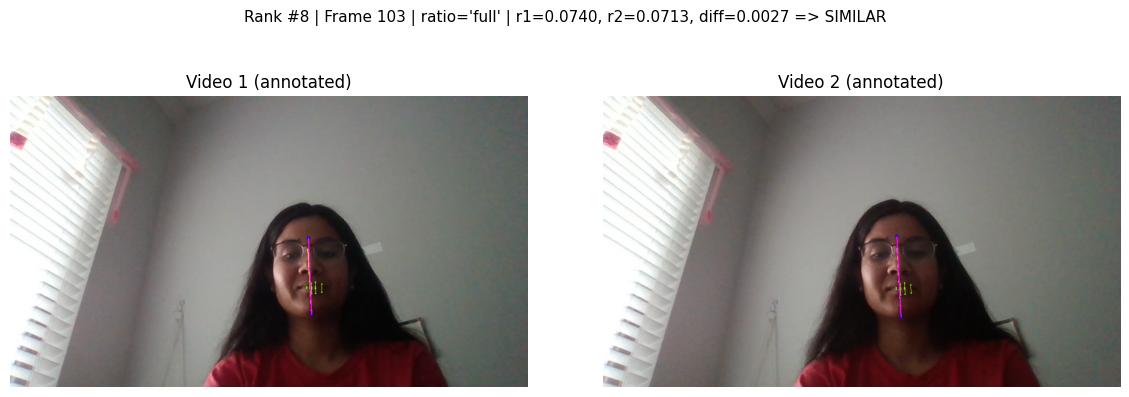

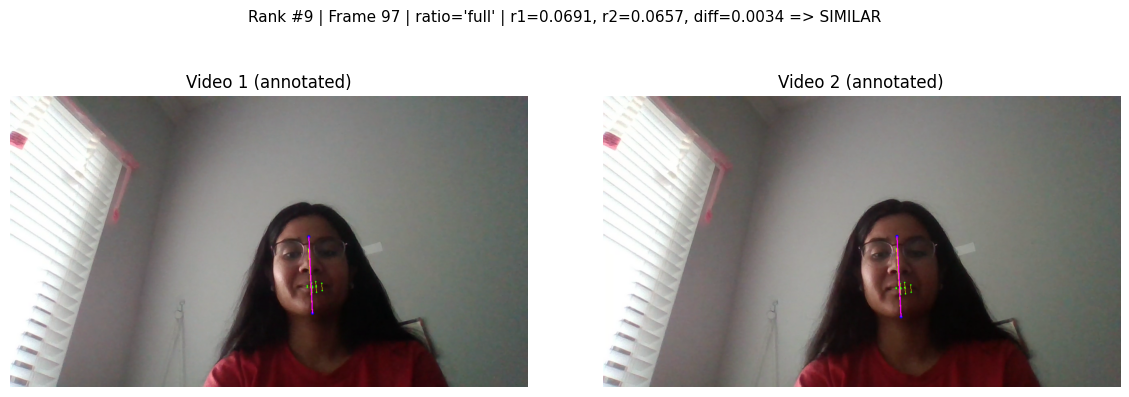

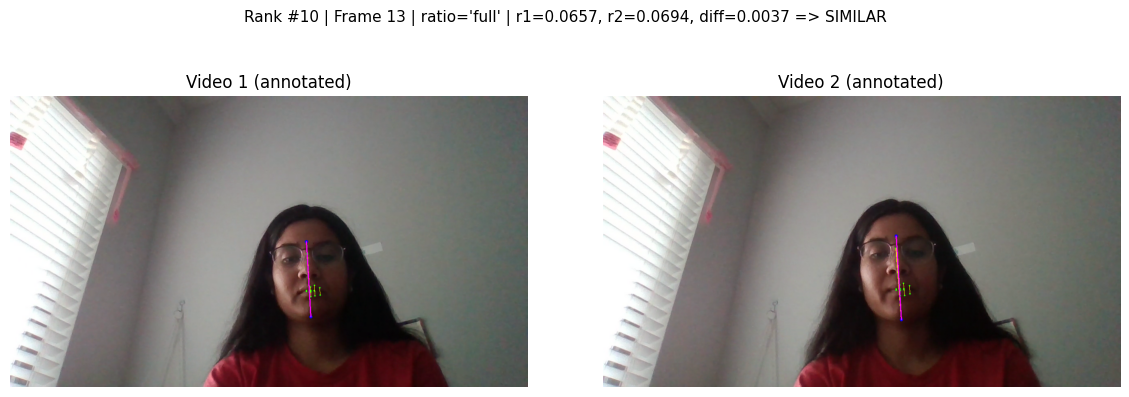

In [3]:
"""
Compare TWO videos (correct vs incorrect) using dlib-68 landmarks + lip/face ratio + FastDTW.
Outputs EVERYTHING in one run:
- per-video landmark detection summary (0-landmark frames, 68-landmark frames, avg valid points)
- per-frame latency stats (avg + p95) and total time per video
- stability (std dev of ratio over still segment)
- per-frame similarity graph (|r1-r2|)
- top-K most similar frames (smallest |diff|), with SIMILAR/NOT similar tag by threshold
- overall FastDTW distance + normalized DTW cost + overall SIMILAR/NOT similar tag
- annotated frame pairs for top-K frames (draws lip/face measurement points/lines)

Requirements:
- pip install dlib opencv-python matplotlib fastdtw
- download shape_predictor_68_face_landmarks.dat and set PREDICTOR_PATH
"""

import os
import time
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

# Optional FastDTW
try:
    from fastdtw import fastdtw
except Exception:
    fastdtw = None



PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"

# Choose which ratio stream to compare:
#   "old"  = (inner lip 62-66) / (nose 27 - chin 8)
#   "full" = mean(inner+outer lip heights) / (brow-mid - chin)
USE_RATIO = "full"


FRAME_DIFF_THRESHOLD = 0.02


DTW_COST_THRESHOLD = 0.02

# Show K most similar frames (smallest per-frame diff)
TOP_K = 10

# Stability window: first N frames assumed "still"
STILL_FRAMES = 30


MAX_FRAMES = None


DRAW_MODE = "both"


if not os.path.exists(PREDICTOR_PATH):
    raise RuntimeError(
        f"Missing predictor file: {PREDICTOR_PATH}\n"
        "Download: shape_predictor_68_face_landmarks.dat and set PREDICTOR_PATH correctly."
    )

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

# dlib indices
UPPER_INNER_LIP = 62
LOWER_INNER_LIP = 66
NOSE_TOP = 27
CHIN = 8

# Whole lip height pairs
INNER_LIP_PAIRS = [(61, 67), (62, 66), (63, 65)]
OUTER_LIP_PAIRS = [(51, 57), (52, 56), (53, 55)]

# Face height proxy
BROW_LEFT = 19
BROW_RIGHT = 24



def shape_to_np(shape):
    pts = np.zeros((68, 2), dtype=np.float32)
    for i in range(68):
        p = shape.part(i)
        pts[i] = (p.x, p.y)
    return pts


def count_valid_inside_image(pts, w, h):
    valid_mask = (
        np.isfinite(pts[:, 0]) & np.isfinite(pts[:, 1]) &
        (pts[:, 0] >= 0) & (pts[:, 0] < w) &
        (pts[:, 1] >= 0) & (pts[:, 1] < h)
    )
    return int(valid_mask.sum()), valid_mask


def mean_pair_distance(pts, pairs):
    dists = [float(np.linalg.norm(pts[i] - pts[j])) for i, j in pairs]
    return float(np.mean(dists)) if dists else np.nan


def get_ratios_and_points_dlib(frame_bgr):
    """
    Returns:
      ratio_old: inner-lip / nose-chin
      ratio_full: whole-lip / browMid-chin
      n_points: 0 or 68
      n_valid:  0..68 valid inside image
      pts: (68,2) array or None
    """
    h, w = frame_bgr.shape[:2]
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 0)
    if not faces:
        return None, None, 0, 0, None

    shape = predictor(gray, faces[0])
    pts = shape_to_np(shape)
    n_points = 68
    n_valid, _ = count_valid_inside_image(pts, w, h)

    # OLD ratio
    lip_open = float(np.linalg.norm(pts[UPPER_INNER_LIP] - pts[LOWER_INNER_LIP]))
    face_h_old = float(np.linalg.norm(pts[NOSE_TOP] - pts[CHIN]))
    ratio_old = None if face_h_old < 1e-6 else (lip_open / face_h_old)

    # FULL ratio
    lip_inner_h = mean_pair_distance(pts, INNER_LIP_PAIRS)
    lip_outer_h = mean_pair_distance(pts, OUTER_LIP_PAIRS)
    lip_whole_h = float(np.nanmean([lip_inner_h, lip_outer_h]))

    brow_mid = (pts[BROW_LEFT] + pts[BROW_RIGHT]) / 2.0
    face_h_full = float(np.linalg.norm(brow_mid - pts[CHIN]))
    ratio_full = None if face_h_full < 1e-6 else (lip_whole_h / face_h_full)

    if not np.isfinite(lip_whole_h):
        ratio_full = None

    return ratio_old, ratio_full, n_points, n_valid, pts


def extract_per_frame(video_path, max_frames=None):
    """
    Returns per-frame arrays aligned to frame index:
      r_old, r_full: float arrays (NaN if no face)
      p_raw: 0 or 68
      p_valid: 0..68 inside image
      per_frame_ms: latency per processed frame (ms)
      total_s: total processing time (sec)
    """
    if not os.path.exists(video_path):
        raise RuntimeError(f"Video not found: {video_path}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")

    r_old, r_full = [], []
    p_raw, p_valid = [], []
    per_frame_ms = []

    total_frames = 0
    detected_frames = 0

    t0 = time.perf_counter()
    while True:
        if max_frames is not None and total_frames >= max_frames:
            break

        ok, frame = cap.read()
        if not ok:
            break

        t_frame0 = time.perf_counter()
        total_frames += 1

        ratio_old, ratio_full, n_pts, n_v, _ = get_ratios_and_points_dlib(frame)

        p_raw.append(n_pts)
        p_valid.append(n_v)

        if ratio_old is None and ratio_full is None:
            r_old.append(np.nan)
            r_full.append(np.nan)
        else:
            r_old.append(np.nan if ratio_old is None else float(ratio_old))
            r_full.append(np.nan if ratio_full is None else float(ratio_full))
            detected_frames += 1

        t_frame1 = time.perf_counter()
        per_frame_ms.append((t_frame1 - t_frame0) * 1000.0)

    cap.release()
    total_s = time.perf_counter() - t0

    det_rate = (detected_frames / total_frames) if total_frames else 0.0
    print(f"{video_path}: frames={total_frames}, detected_frames={detected_frames}, detection_rate={det_rate:.1%}")

    return (
        np.array(r_old, dtype=np.float32),
        np.array(r_full, dtype=np.float32),
        np.array(p_raw, dtype=np.int32),
        np.array(p_valid, dtype=np.int32),
        np.array(per_frame_ms, dtype=np.float32),
        float(total_s),
    )


def fastdtw_similarity(a, b):
    """
    Returns (dist, path_len, normalized_cost) or (None,None,None)
    normalized_cost = dist / path_len
    """
    if fastdtw is None:
        return None, None, None

    mask = np.isfinite(a) & np.isfinite(b)
    aa = a[mask].astype(float)
    bb = b[mask].astype(float)
    if len(aa) < 2 or len(bb) < 2:
        return None, None, None

    dist, path = fastdtw(aa, bb)
    path_len = len(path) if path is not None else max(len(aa), len(bb))
    cost = float(dist) / (float(path_len) + 1e-9)
    return float(dist), int(path_len), float(cost)


def print_landmark_summary(video1_path, video2_path, p1, p2, pv1, pv2):
    n = min(len(p1), len(p2))
    p1, p2, pv1, pv2 = p1[:n], p2[:n], pv1[:n], pv2[:n]

    v1_zero = int(np.sum(p1 == 0))
    v2_zero = int(np.sum(p2 == 0))
    both_zero = int(np.sum((p1 == 0) & (p2 == 0)))

    v1_full = int(np.sum(p1 == 68))
    v2_full = int(np.sum(p2 == 68))
    both_full = int(np.sum((p1 == 68) & (p2 == 68)))

    print("\nFacial landmark detection summary (dlib-68):")
    print(f"  Total aligned frames compared: {n}")
    print(f"  {video1_path}: frames with 0 landmarks = {v1_zero}, frames with 68 landmarks = {v1_full}")
    print(f"  {video2_path}: frames with 0 landmarks = {v2_zero}, frames with 68 landmarks = {v2_full}")
    print(f"  Both videos: frames where BOTH had 0 landmarks = {both_zero}")
    print(f"  Both videos: frames where BOTH had full 68 landmarks = {both_full}")

    if np.any(p1 == 68):
        print(f"  Mean valid points (when detected) video1: {pv1[p1==68].mean():.2f} / 68")
    else:
        print("  Mean valid points (when detected) video1: N/A")

    if np.any(p2 == 68):
        print(f"  Mean valid points (when detected) video2: {pv2[p2==68].mean():.2f} / 68")
    else:
        print("  Mean valid points (when detected) video2: N/A")


def compute_stability(r, still_frames=30):
    """Std dev of ratio during still segment (first still_frames finite values)."""
    r = np.asarray(r, dtype=float)
    finite_idx = np.where(np.isfinite(r))[0]
    if len(finite_idx) == 0:
        return np.nan
    # take first N finite samples
    take = finite_idx[:still_frames]
    if len(take) < 2:
        return np.nan
    return float(np.std(r[take]))


def plot_per_frame_diff(r1, r2, threshold=0.02, title="Per-frame |r1-r2|"):
    diff = np.abs(r1 - r2)
    mask = np.isfinite(diff)
    idx = np.where(mask)[0]
    d = diff[mask]
    if len(d) == 0:
        print("No overlapping finite ratios to plot.")
        return
    plt.figure(figsize=(12, 4))
    plt.plot(idx, d)
    plt.axhline(threshold, linestyle="--")
    plt.title(f"{title} (threshold={threshold})")
    plt.xlabel("Frame index")
    plt.ylabel("|ratio1 - ratio2|")
    plt.tight_layout()
    plt.show()


def get_frame_at(video_path, frame_idx):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
    ok, frame = cap.read()
    cap.release()
    return frame if ok else None


def draw_points_and_lines(frame_bgr, pts, mode="both"):
    """
    Draw lip + face measurement points/lines on the frame.
    mode: "old", "full", "both"
    """
    if pts is None:
        return frame_bgr
    img = frame_bgr.copy()

    def circle_xy(x, y, radius=3, color=(0, 255, 0)):
        cv2.circle(img, (int(x), int(y)), int(radius), color, -1)

    def circle(i, radius=3, color=(0, 255, 0)):
        x, y = pts[i]
        circle_xy(x, y, radius=radius, color=color)

    def line(i, j, thickness=2, color=(0, 255, 255)):
        x1, y1 = pts[i]
        x2, y2 = pts[j]
        cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, int(thickness))

    # OLD markers
    if mode in ("old", "both"):
        for i in [UPPER_INNER_LIP, LOWER_INNER_LIP, NOSE_TOP, CHIN]:
            circle(i, radius=3, color=(0, 255, 0))
        line(UPPER_INNER_LIP, LOWER_INNER_LIP, thickness=2, color=(0, 255, 255))
        line(NOSE_TOP, CHIN, thickness=2, color=(0, 255, 255))

    # FULL markers
    if mode in ("full", "both"):
        # lip pairs
        for i, j in INNER_LIP_PAIRS + OUTER_LIP_PAIRS:
            circle(i, radius=2, color=(0, 255, 0))
            circle(j, radius=2, color=(0, 255, 0))
            line(i, j, thickness=1, color=(0, 255, 255))

        # brow-mid to chin
        brow_mid = (pts[BROW_LEFT] + pts[BROW_RIGHT]) / 2.0
        bx, by = brow_mid
        cx, cy = pts[CHIN]
        circle_xy(bx, by, radius=4, color=(255, 0, 0))
        circle(CHIN, radius=4, color=(255, 0, 0))
        cv2.line(img, (int(bx), int(by)), (int(cx), int(cy)), (255, 0, 255), 2)

    return img



def compare_two_videos(
    video1_path,
    video2_path,
    use_ratio="full",
    frame_diff_threshold=0.02,
    dtw_cost_threshold=0.02,
    top_k=10,
    still_frames=30,
    max_frames=None,
    draw_mode="both",
):
    print("\n EXTRACT PER-FRAME ")
    r1_old, r1_full, p1, pv1, lat1_ms, total1_s = extract_per_frame(video1_path, max_frames=max_frames)
    r2_old, r2_full, p2, pv2, lat2_ms, total2_s = extract_per_frame(video2_path, max_frames=max_frames)

    # Trim all to same length
    n = min(len(r1_old), len(r2_old))
    r1_old, r1_full, p1, pv1, lat1_ms = r1_old[:n], r1_full[:n], p1[:n], pv1[:n], lat1_ms[:n]
    r2_old, r2_full, p2, pv2, lat2_ms = r2_old[:n], r2_full[:n], p2[:n], pv2[:n], lat2_ms[:n]

    r1 = r1_full if use_ratio == "full" else r1_old
    r2 = r2_full if use_ratio == "full" else r2_old

    print("\n LANDMARK SUMMARY ")
    print_landmark_summary(video1_path, video2_path, p1, p2, pv1, pv2)

    print("\n LATENCY ")
    def latency_stats(arr_ms):
        if len(arr_ms) == 0:
            return np.nan, np.nan
        return float(np.mean(arr_ms)), float(np.percentile(arr_ms, 95))

    lat1_avg, lat1_p95 = latency_stats(lat1_ms)
    lat2_avg, lat2_p95 = latency_stats(lat2_ms)
    print(f"Video1 latency: avg={lat1_avg:.2f} ms/frame, p95={lat1_p95:.2f} ms, total_time={total1_s:.2f} s")
    print(f"Video2 latency: avg={lat2_avg:.2f} ms/frame, p95={lat2_p95:.2f} ms, total_time={total2_s:.2f} s")

    print("\n STABILITY (still segment) ")
    stab1 = compute_stability(r1, still_frames=still_frames)
    stab2 = compute_stability(r2, still_frames=still_frames)
    print(f"Stability σ (video1, first {still_frames} finite frames): {stab1:.6f}")
    print(f"Stability σ (video2, first {still_frames} finite frames): {stab2:.6f}")

    print("\n PER-FRAME SIMILARITY GRAPH ")
    plot_per_frame_diff(r1, r2, threshold=frame_diff_threshold, title=f"Per-frame |r1-r2| using ratio='{use_ratio}'")

    print("\n TOP-K MOST SIMILAR FRAMES ")
    mask = np.isfinite(r1) & np.isfinite(r2)
    valid_idx = np.where(mask)[0]
    if len(valid_idx) == 0:
        print("No overlapping frames with valid ratios in both videos.")
        return

    diff = np.abs(r1[valid_idx] - r2[valid_idx])
    order = np.argsort(diff)  # ascending
    top = valid_idx[order[: min(top_k, len(order))]]

    print(f"Using ratio='{use_ratio}' | per-frame SIMILAR if |diff| <= {frame_diff_threshold}")
    for idx in top:
        d = float(abs(r1[idx] - r2[idx]))
        tag = "SIMILAR" if d <= frame_diff_threshold else "NOT similar"
        print(
            f"  Frame {idx}: r1={r1[idx]:.4f}, r2={r2[idx]:.4f}, |diff|={d:.4f} => {tag} | "
            f"pts1={p1[idx]}(valid {pv1[idx]}), pts2={p2[idx]}(valid {pv2[idx]})"
        )

    print("\n OVERALL FastDTW ")
    dist, path_len, cost = fastdtw_similarity(r1, r2)
    if cost is None:
        print("FastDTW not available or not enough valid points. Install with: pip install fastdtw")
    else:
        overall_tag = "SIMILAR" if cost <= dtw_cost_threshold else "NOT similar"
        print(f"FastDTW: dist={dist:.6f}, path_len={path_len}, dtw_cost={cost:.6f} => {overall_tag} (threshold={dtw_cost_threshold})")
        # Optional similarity scalar (0..1-ish)
        sim = 1.0 / (1.0 + cost)
        print(f"DTW-derived similarity (1/(1+cost)) = {sim:.6f}")

    print("\n TOP-K FRAMES ")
    for rank, idx in enumerate(top, start=1):
        f1 = get_frame_at(video1_path, idx)
        f2 = get_frame_at(video2_path, idx)
        if f1 is None or f2 is None:
            print(f"Could not load frame {idx} from one of the videos, skipping.")
            continue

        # recompute pts for drawing
        _, _, _, _, pts1 = get_ratios_and_points_dlib(f1)
        _, _, _, _, pts2 = get_ratios_and_points_dlib(f2)

        a1 = draw_points_and_lines(f1, pts1, mode=draw_mode)
        a2 = draw_points_and_lines(f2, pts2, mode=draw_mode)

        a1_rgb = cv2.cvtColor(a1, cv2.COLOR_BGR2RGB)
        a2_rgb = cv2.cvtColor(a2, cv2.COLOR_BGR2RGB)

        d = float(abs(r1[idx] - r2[idx]))
        tag = "SIMILAR" if d <= frame_diff_threshold else "NOT similar"

        plt.figure(figsize=(12, 4))
        plt.suptitle(
            f"Rank #{rank} | Frame {idx} | ratio='{use_ratio}' | r1={r1[idx]:.4f}, r2={r2[idx]:.4f}, diff={d:.4f} => {tag}",
            fontsize=11
        )
        plt.subplot(1, 2, 1)
        plt.imshow(a1_rgb); plt.axis("off"); plt.title("Video 1 (annotated)")

        plt.subplot(1, 2, 2)
        plt.imshow(a2_rgb); plt.axis("off"); plt.title("Video 2 (annotated)")

        plt.tight_layout(rect=[0, 0, 1, 0.88])
        plt.show()



if __name__ == "__main__":

    video1 = "/content/vidS1.mp4"         # correct/reference
    video2 = "/content/vidS2.mp4"          # incorrect/test

    compare_two_videos(
        video1_path=video1,
        video2_path=video2,
        use_ratio=USE_RATIO,
        frame_diff_threshold=FRAME_DIFF_THRESHOLD,
        dtw_cost_threshold=DTW_COST_THRESHOLD,
        top_k=TOP_K,
        still_frames=STILL_FRAMES,
        max_frames=MAX_FRAMES,
        draw_mode=DRAW_MODE,
    )
